<a href="https://colab.research.google.com/github/AyorindeTayo/ANN-prediction-of-Hardness-using-Tensor-Flow/blob/master/ANNhardness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

In [20]:
print(tf.__version__)

2.3.0


In [21]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fy3r9bnv
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-fy3r9bnv
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.09727d0fbd24b31942ca26f21ba4045326c318baa_-cp36-none-any.whl size=141477 sha256=80509227436cb19a7e58a77941c2c7246c32abc174db505aaaefc7e74bf71b6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vl40_zlj/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


# A quick exploratory data analysis

In [22]:
from google.colab import files
files.upload()

Saving data_1004.xlsx to data_1004 (1).xlsx


{'data_1004.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\xa7\x0c\xebyh\x01\x00\x00\r\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [23]:
df=pd.read_excel('data_1004.xlsx')
df.head()

,S-temp,S-time,Wel-power,Wel-speed,Hardness
0,1000,5,1500,3,343.7
1,1000,5,1500,3,350.1
2,1000,5,1500,3,351.7
3,1000,5,1500,3,365.6
4,1000,5,1500,3,337.5


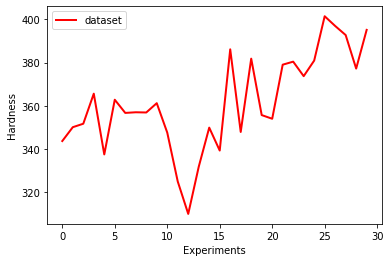

In [24]:
plt.plot(df.index, df['Hardness'], color='r', lw=2, label='dataset')
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.legend()
plt.show()

# Preparation of the data for training

In [25]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [26]:
train_stats = train_dataset.describe()
train_stats.pop("Hardness")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
S-temp,24.0,1000.000000,83.405766,900.0,900.0,1000.0,1100.0,1100.0
S-time,24.0,6.666667,2.407717,5.0,5.0,5.0,10.0,10.0
Wel-power,24.0,1733.333333,209.899907,1500.0,1500.0,1700.0,2000.0,2000.0
Wel-speed,24.0,2.666667,0.481543,2.0,2.0,3.0,3.0,3.0


In [27]:
train_labels = train_dataset.pop('Hardness')
test_labels = test_dataset.pop('Hardness')

# Defining the function to normalize the data

In [28]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


# Defining the shallow neural network model

In [32]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [33]:
model = build_model()

# Training and validation of the model

In [34]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [35]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:133050.2656,  mae:364.1778,  mse:133050.2656,  val_loss:128715.6016,  val_mae:358.4882,  val_mse:128715.6016,  
....................................................................................................
Epoch: 100, loss:116907.3281,  mae:341.5856,  mse:116907.3281,  val_loss:120109.1250,  val_mae:346.3214,  val_mse:120109.1250,  
....................................................................................................
Epoch: 200, loss:74689.8828,  mae:270.4016,  mse:74689.8828,  val_loss:96428.7266,  val_mae:310.3115,  val_mse:96428.7266,  
....................................................................................................
Epoch: 300, loss:27988.9336,  mae:141.2688,  mse:27988.9336,  val_loss:52364.3750,  val_mae:227.8514,  val_mse:52364.3750,  
....................................................................................................
Epoch: 400, loss:3993.7571,  mae:44.0879,  mse:3993.7571,  val_loss:8377.5020,  val_mae:8

# Learning and validation results

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,198.000687,9.581100,198.000687,300.681427,12.737177,300.681427,995
996,197.994156,9.699625,197.994156,323.837921,13.824762,323.837921,996
997,198.023071,9.575768,198.023071,302.115387,12.780255,302.115387,997
998,198.019562,9.697238,198.019562,322.914642,13.799817,322.914642,998
999,198.036819,9.572940,198.036819,302.046417,12.778290,302.046417,999


# Plotting the results

In [37]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=3)

Text(0, 0.5, 'MAE [Hardness]')

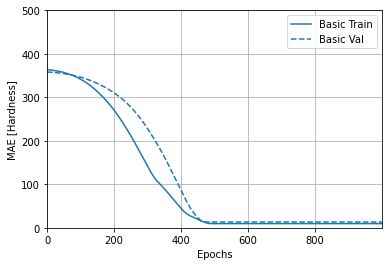

In [38]:
plotter.plot({'Basic': history}, metric = 'mae')
plt.ylim([0, 500])
plt.ylabel('MAE [Hardness]')   #mean_absolute_error

#plt.savefig('1.pdf')

#files.download('1.pdf')

Text(0, 0.5, 'MSE [Hardness]')

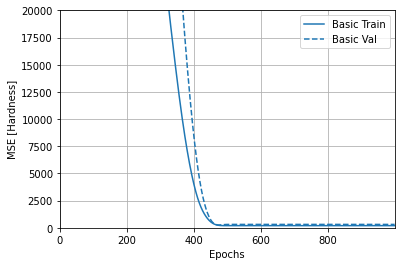

In [39]:
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0, 20000])
plt.ylabel('MSE [Hardness]') #mean_squared_error

#plt.savefig('2.pdf')

#files.download('2.pdf')

In [40]:
loss, mae, mse = model.evaluate(normed_train_data, train_labels, verbose=2)

print("Training Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 219.6845 - mae: 10.3388 - mse: 219.6845
Training Mean Abs Error: 10.34 Hardness


In [41]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 367.7660 - mae: 15.4716 - mse: 367.7660
Testing set Mean Abs Error: 15.47 Hardness


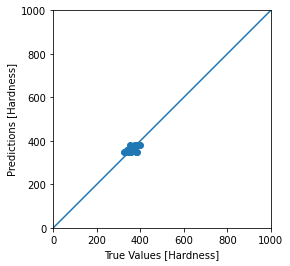

In [43]:
train_predictions = model.predict(normed_train_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#plt.savefig('3.pdf')

#files.download('3.pdf')

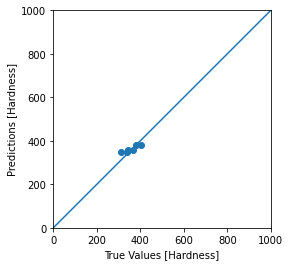

In [45]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#plt.savefig('4.pdf')

#files.download('4.pdf')

In [46]:
t1=np.corrcoef(test_labels, test_predictions)[0,1]
k1=np.corrcoef(train_labels, train_predictions)[0,1]
print('the corralation on the training set is',t1,'and that on the test set is',k1)

the corralation on the training set is 0.8767316092338837 and that on the test set is 0.6570117313996204


In [47]:
train_pred = model.predict(normed_train_data).flatten()
test_pred = model.predict(normed_test_data).flatten()

err1 = 100*(np.abs(test_pred - test_labels))/test_labels
err2=100*(np.abs(train_pred - train_labels))/train_labels

In [48]:
print(test_labels)
print('-'*50)
print(test_pred)
print('-'*50)
print(err1)

0     343.7
3     365.6
12    310.0
15    339.3
21    379.0
25    401.4
Name: Hardness, dtype: float64
--------------------------------------------------
[356.4789  356.4789  348.91483 348.91483 383.04413 383.04413]
--------------------------------------------------
0      3.718043
3      2.494827
12    12.553169
15     2.833724
21     1.067052
25     4.572963
Name: Hardness, dtype: float64


In [49]:
print(train_labels)
print('-'*50)
print(train_pred)
print('-'*50)
print(err2)

2     351.7
28    377.2
13    331.8
10    347.6
26    396.9
24    380.9
27    392.7
11    325.0
17    347.9
22    380.4
5     362.8
16    386.1
8     356.9
14    349.9
23    373.7
20    354.0
1     350.1
29    395.1
6     356.7
4     337.5
18    381.8
19    355.7
9     361.2
7     357.0
Name: Hardness, dtype: float64
--------------------------------------------------
[356.47894 383.04413 348.91483 348.91483 383.04413 383.04413 383.04413
 348.91483 348.91483 383.04413 356.47894 348.91483 356.47894 348.91483
 383.04413 383.04413 356.47894 383.04413 356.47894 356.47894 348.91483
 348.91483 356.47894 356.47894]
--------------------------------------------------
2     1.358812
28    1.549345
13    5.158175
10    0.378258
26    3.491023
24    0.562911
27    2.458842
11    7.358408
17    0.291700
22    0.695092
5     1.742298
16    9.630970
8     0.117976
14    0.281559
23    2.500436
20    8.204556
1     1.822035
29    3.051347
6     0.061973
4     5.623390
18    8.613194
19    1.907555
9   

# Model with early stopping

In [50]:
model1 = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model1.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])



Epoch: 0, loss:132959.8125,  mae:364.0548,  mse:132959.8125,  val_loss:128684.2266,  val_mae:358.4489,  val_mse:128684.2266,  
....................................................................................................
Epoch: 100, loss:116352.9453,  mae:340.7383,  mse:116352.9453,  val_loss:118030.2734,  val_mae:343.3095,  val_mse:118030.2734,  
....................................................................................................
Epoch: 200, loss:71111.4062,  mae:264.7134,  mse:71111.4062,  val_loss:88477.7734,  val_mae:297.2186,  val_mse:88477.7734,  
....................................................................................................
Epoch: 300, loss:22121.5293,  mae:126.5930,  mse:22121.5293,  val_loss:41691.5352,  val_mae:202.8698,  val_mse:41691.5352,  
....................................................................................................
Epoch: 400, loss:2047.4132,  mae:31.1156,  mse:2047.4132,  val_loss:4069.4004,  val_mae:5

# Results of the model with early stopping

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

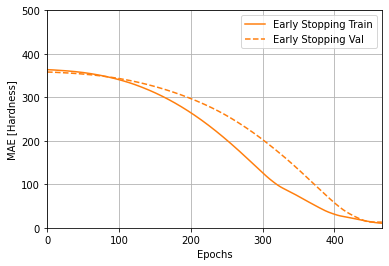

In [51]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 500])
plt.ylabel('MAE [Hardness]') #mean_absolute_error

plt.savefig('5.pdf')

files.download('5.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

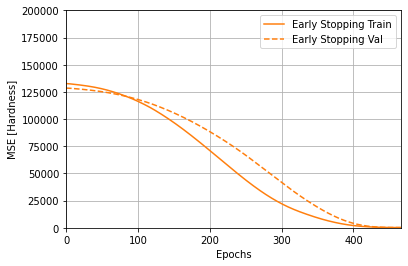

In [52]:
plotter.plot({'Early Stopping': early_history}, metric = "mse")
plt.ylim([0, 200000])
plt.ylabel('MSE [Hardness]') #mean_squared_error

plt.savefig('6.pdf')

files.download('6.pdf')

# Training loss

In [54]:
loss, mae, mse = model1.evaluate(normed_train_data, train_labels, verbose=2)

print("Training set Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 215.9298 - mae: 10.7576 - mse: 215.9298
Training set Mean Abs Error: 10.76 Hardness


# Test loss

In [55]:
loss, mae, mse = model1.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Hardness".format(mae))


1/1 - 0s - loss: 398.1672 - mae: 16.0129 - mse: 398.1672
Testing set Mean Abs Error: 16.01 Hardness


# Training plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

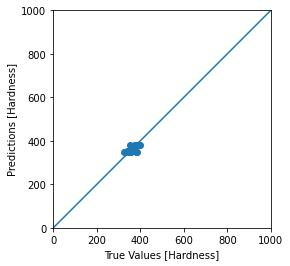

In [56]:
train_predictions = model1.predict(normed_train_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

plt.savefig('7.pdf')

files.download('7.pdf')

# Test plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

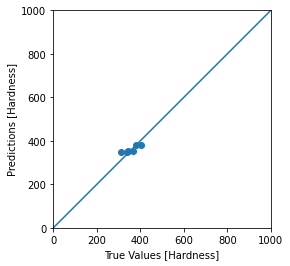

In [57]:
test_predictions = model1.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

plt.savefig('8.pdf')

files.download('8.pdf')

In [58]:
test_predictions 

array([351.76492, 351.76492, 350.53864, 350.53864, 382.71725, 382.71725],
      dtype=float32)

# Corralation coefficient

In [59]:
t=np.corrcoef(test_labels, test_predictions)[0,1]
k=np.corrcoef(train_labels, train_predictions)[0,1]
print('the corralation on the training set is',t,'and that on the test set is',k)

the corralation on the training set is 0.8208507240255621 and that on the test set is 0.6679061244149478


# Percentage Errors on the predictions

The percentage error is defined as follows:

$$PE= 100\times \Big| \dfrac{TV-PV}{TV}\Big |$$

Where $TV$, $PV$ are the true values and the predicted value respectively.

In [60]:
error1 = 100*(np.abs(test_predictions - test_labels))/test_labels
error2=100*(np.abs(train_predictions - train_labels))/train_labels

In [61]:
print(test_labels)
print('-'*50)
print(test_predictions)
print('-'*50)
print(error1)

0     343.7
3     365.6
12    310.0
15    339.3
21    379.0
25    401.4
Name: Hardness, dtype: float64
--------------------------------------------------
[351.76492 351.76492 350.53864 350.53864 382.71725 382.71725]
--------------------------------------------------
0      2.346501
3      3.784211
12    13.076979
15     3.312300
21     0.980806
25     4.654396
Name: Hardness, dtype: float64


In [62]:
print(train_labels)
print('-'*50)
print(train_predictions)
print('-'*50)
print(error2)

2     351.7
28    377.2
13    331.8
10    347.6
26    396.9
24    380.9
27    392.7
11    325.0
17    347.9
22    380.4
5     362.8
16    386.1
8     356.9
14    349.9
23    373.7
20    354.0
1     350.1
29    395.1
6     356.7
4     337.5
18    381.8
19    355.7
9     361.2
7     357.0
Name: Hardness, dtype: float64
--------------------------------------------------
[351.76492 382.71725 350.53867 350.53867 382.71725 382.71725 382.71725
 350.53867 350.53867 382.71725 351.76492 350.53867 351.76492 350.53867
 382.71725 382.71725 351.76492 382.71725 351.76492 351.76492 350.53867
 350.53867 351.76492 351.76492]
--------------------------------------------------
2     0.018460
28    1.462687
13    5.647579
10    0.845416
26    3.573380
24    0.477095
27    2.542079
11    7.858051
17    0.758455
22    0.609163
5     3.041642
16    9.210395
8     1.438800
14    0.182528
23    2.412966
20    8.112219
1     0.475556
29    3.134079
6     1.383537
4     4.226644
18    8.187882
19    1.451036
9   

In [63]:
test_predictions

array([351.76492, 351.76492, 350.53864, 350.53864, 382.71725, 382.71725],
      dtype=float32)

# Trying something

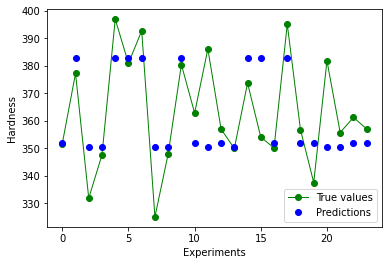

In [64]:
k=pd.Series(train_labels).reset_index(drop=True)
m=pd.Series(train_predictions).reset_index(drop=True)

plt.plot(k.index, k, color='green',marker='o', label='True values', lw=1)
plt.plot(m.index,m, 'bo', label='Predictions')
plt.legend()
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.show()

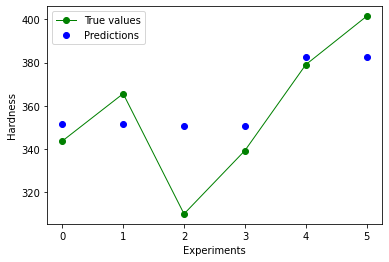

In [65]:
l=pd.Series(test_labels).reset_index(drop=True)
n=pd.Series(test_predictions).reset_index(drop=True)

plt.plot(l.index, l, color='green',marker='o', label='True values', lw=1)
plt.plot(n.index,n, 'bo', label='Predictions')
plt.legend()
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.show()

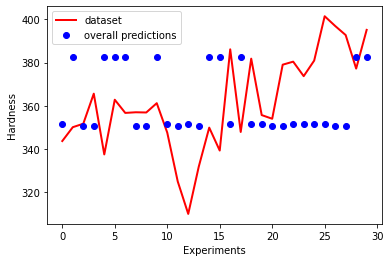

In [66]:
d_f=pd.concat([pd.Series(train_predictions),pd.Series(test_predictions)])

plt.plot(df.index, df['Hardness'], color='r', label='dataset', lw=2)
plt.plot(df.index, d_f, 'bo', label='overall predictions')
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.legend()
plt.show()


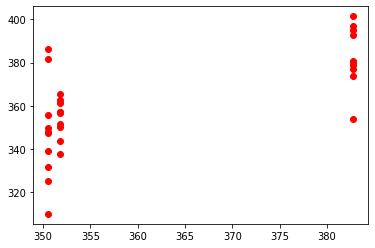

In [67]:
dff=pd.concat([pd.Series(train_labels),pd.Series(test_labels)])
plt.scatter(d_f, dff, color='r', label='dataset')


#plt.savefig('test.pdf')

#files.download('test.pdf')

In [68]:



def build_modell():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), 
    activity_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model




model2 = build_modell()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model1.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:203.0785,  mae:10.1486,  mse:203.0785,  val_loss:272.1335,  val_mae:13.2444,  val_mse:272.1335,  
....................................................................................................
Epoch: 100, loss:198.0290,  mae:9.7059,  mse:198.0290,  val_loss:327.3683,  val_mae:13.9251,  val_mse:327.3683,  
....................................................................................................
Epoch: 200, loss:198.0298,  mae:9.7060,  mse:198.0298,  val_loss:327.2325,  val_mae:13.9213,  val_mse:327.2325,  
....................................................................................................
Epoch: 300, loss:198.0332,  mae:9.7070,  mse:198.0332,  val_loss:327.9802,  val_mae:13.9431,  val_mse:327.9802,  
....................................................................................................
Epoch: 400, loss:198.0278,  mae:9.7059,  mse:198.0278,  val_loss:328.0680,  val_mae:13.9449,  val_mse:328.0680,  
..........................

In [69]:
loss, mae, mse = model2.evaluate(normed_train_data, train_labels, verbose=2)

print("Training set Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 132039.4688 - mae: 362.8491 - mse: 132038.8281
Training set Mean Abs Error: 362.85 Hardness


dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


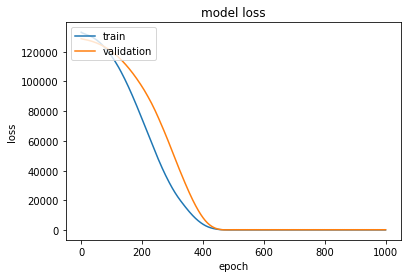

In [70]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [72]:
from sklearn.metrics import r2_score

r2_score(test_labels , test_predictions)

0.5429494615664885

In [73]:
r2_score(train_labels, train_predictions)

0.4328220194960376

In [123]:
Validation_data=(test_labels,test_predictions )

In [124]:
print(Validation_data)


(0     343.7
3     365.6
12    310.0
15    339.3
21    379.0
25    401.4
Name: Hardness, dtype: float64, array([351.76492, 351.76492, 350.53864, 350.53864, 382.71725, 382.71725],
      dtype=float32))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

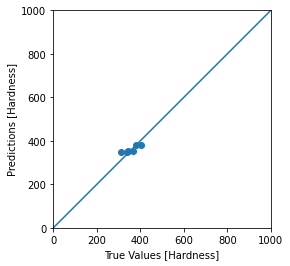

In [105]:
Validation predictions = model1.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


plt.savefig('8.pdf')

files.download('8.pdf')

In [76]:
import numpy


import matplotlib.pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
numpy.random.seed(78)


In [77]:
import pandas as pd

weldingdata=pd.read_excel('data_1004.xlsx')
df=weldingdata

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import metrics


X=df[['S-temp','S-time', 'Wel-power', 'Wel-speed']]
y=df['Hardness']